### Readme
This notebook leverages a basic neural net to predict mnist images. It then uses the shap library to graphically interpret the weights.

Based in https://github.com/slundberg/shap

### Imports and data load

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shap

# to avoid a certificates issue run the following 2 lines:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

11493376/11490434 [==============================] - 57s 5us/step


In [ ]:
mnist = tf.keras.datasets.mnist #28*28 images 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Explore and clean data

In [5]:
x_train = tf.keras.utils.normalize(x_train,axis=1)
x_test = tf.keras.utils.normalize(x_test,axis=1)

In [6]:
print(x_train[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

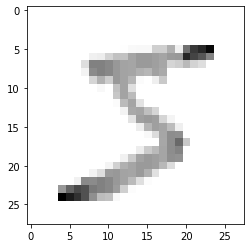

In [7]:
plt.imshow(x_train[0], cmap = plt.cm.binary)
plt.show()

### Model
This is a simple architecture with minimal training:

2 fully connected hidden layers and a final layer to output the probabilities

In [32]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())# input is a 28*28 multidimensional array 
# ->since we don't have a conv model we need to flatten the input
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
#we used softmax to get a probability distrubution

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2571 - accuracy: 0.9255: 0s - los
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1056 - accuracy: 0.9672
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0727 - accuracy: 0.9774: 0s - loss: 0
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0524 - accuracy: 0.9830: 0s - l
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0409 - accuracy: 0.9867
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0310 - accuracy: 0.9903
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0249 - accuracy: 0.9916
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0221 - accuracy: 0.9927
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0177 - accuracy: 0.9940
Epoch 10/10
1875/1875 [===========================

In [33]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 937us/step - loss: 0.1218 - accuracy: 0.9720


In [29]:
model.save('my_model.model')
new_model = tf.keras.models.load_model('my_model.model')
predictions = new_model.predict([x_test])


INFO:tensorflow:Assets written to: my_model.model/assets


[[1.34731709e-29 5.82685323e-24 7.28669379e-22 ... 1.00000000e+00
  1.12472628e-20 2.42961528e-16]
 [2.27867975e-24 3.36457875e-11 1.00000000e+00 ... 1.03098772e-23
  8.04178612e-24 4.73270552e-37]
 [2.14512762e-22 1.00000000e+00 2.19435505e-16 ... 2.67763145e-10
  2.37993514e-11 9.97900315e-16]
 ...
 [5.14006462e-23 1.30920605e-22 7.00299140e-25 ... 1.26889547e-13
  6.50980904e-15 2.59543748e-10]
 [1.39989829e-29 2.82532387e-24 5.02149701e-29 ... 3.47228449e-21
  1.10738285e-11 4.66706012e-26]
 [6.02305488e-20 2.75449390e-29 4.10641594e-25 ... 4.18658770e-35
  8.62475537e-22 2.90576654e-28]]
7


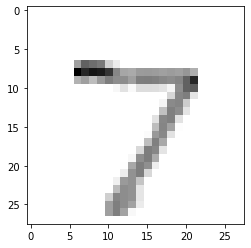

In [30]:
print(predictions) #prints the arrays with prob distributions
print(np.argmax(predictions[0])) # the most likely pred for sample 0
plt.imshow(x_test[0], cmap = plt.cm.binary)
plt.show()

### Explain model with shap's DeepExplainer

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

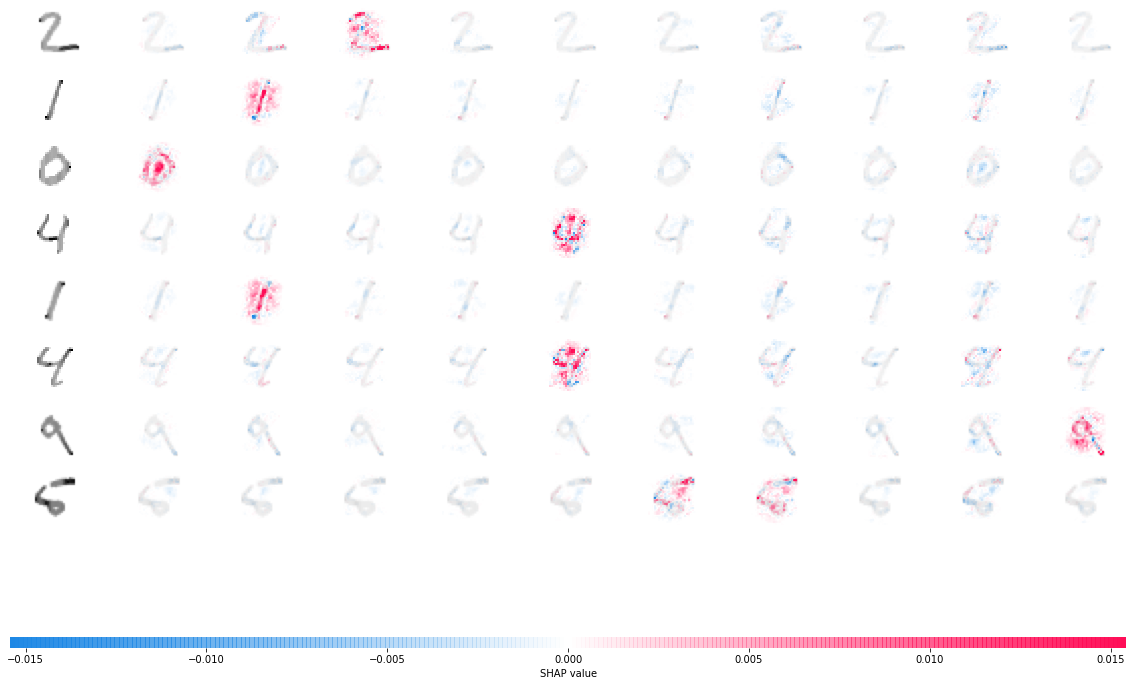

In [34]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on eight images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:9])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:9])

In [35]:
!pip3 freeze>requirements.txt